In [3]:
!pip list

zsh:1: /Users/marco/Documents/project/machine_learning/langgraph/multi_agents/.venv_lang/bin/pip: bad interpreter: /Users/marco/Documents/project/machine_learning/langgraph_basic/.venv_lang/bin/python3: no such file or directory


In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import Runnable, RunnablePassthrough
from langgraph.prebuilt import create_react_agent
from langchain.agents.agent import AgentExecutor
# from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, List, Dict, Any, Annotated, Literal
from duckduckgo_search import DDGS
from langchain_core.tools import Tool, tool



import pandas as pd
import requests
import json
import time
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import operator


from IPython.display import display, Markdown, Latex, Image

In [5]:
llm = ChatOpenAI(temperature=0)

# State

In [6]:
# Tipe data untuk state
class AgentState(TypedDict):
    messages: Annotated[list, operator.add]
    # next: str
    bitcoin_data: Dict
    news_data: str
    technical_analysis: Dict
    news_analysis_report: str
    report: str

# Fungsi untuk memformat pesan ke format yang dapat diproses oleh model
def format_messages(state):
    return {"messages": state["messages"]}

# Tools & Agent

## Price Analyst

### 1. Researcher

In [7]:
# 1. RESEARCHER / DATA ENGINEER AGENT
# Bertanggung jawab untuk mengambil data dari CoinGecko
def fetch_bitcoin_data() -> Dict:
    """Mengambil data Bitcoin dari CoinGecko API"""
    # Endpoint untuk data historis Bitcoin
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    
    # Parameter untuk data 30 hari terakhir
    end_date = datetime.now()
    start_date = end_date - timedelta(days=30)
    
    params = {
        "vs_currency": "usd",
        "days": "30",
        "interval": "daily"
    }
    
    try:
        response = requests.get(url, params=params)
        data = response.json()
        
        # Proses data untuk dibuat lebih terstruktur
        prices = data.get("prices", [])
        volumes = data.get("total_volumes", [])
        market_caps = data.get("market_caps", [])
        
        processed_data = []
        for i in range(len(prices)):
            timestamp = prices[i][0]
            date = datetime.fromtimestamp(timestamp/1000).strftime('%Y-%m-%d')
            price = prices[i][1]
            volume = volumes[i][1] if i < len(volumes) else None
            market_cap = market_caps[i][1] if i < len(market_caps) else None
            
            processed_data.append({
                "date": date,
                "price": price,
                "volume": volume,
                "market_cap": market_cap
            })
        
        return {
            "data": processed_data,
            "status": "success",
            "message": f"Berhasil mengambil data Bitcoin untuk {len(processed_data)} hari terakhir"
        }
    except Exception as e:
        return {
            "data": [],
            "status": "error",
            "message": f"Gagal mengambil data: {str(e)}"
        }

def researcher_agent(state: AgentState) -> AgentState:
    """Agent yang bertugas mengambil dan menyiapkan data Bitcoin"""
    # Mengambil data dari CoinGecko
    bitcoin_data = fetch_bitcoin_data()
    
    # Mempersiapkan pesan untuk agent berikutnya
    if bitcoin_data["status"] == "success":
        researcher_message = {
            "role": "assistant",
            "content": f"Saya telah mengambil data Bitcoin dari CoinGecko. {bitcoin_data['message']}. Data siap untuk dianalisis."
        }
    else:
        researcher_message = {
            "role": "assistant",
            "content": f"Terjadi kesalahan saat mengambil data: {bitcoin_data['message']}"
        }
    
    # Update state
    new_messages = state["messages"] + [researcher_message]
    
    return {
        "messages": new_messages,
        # "next": "analyst" if bitcoin_data["status"] == "success" else END,
        "bitcoin_data": bitcoin_data,
        # "technical_analysis": state.get("technical_analysis", {}),
        # "report": state.get("report", "")
    }



### 2. Analyst

In [8]:
# 2. ANALYST AGENT
# Bertanggung jawab untuk menganalisa indikator teknikal
def calculate_technical_indicators(data):
    """Menghitung indikator teknikal RSI, EMA, dan MACD"""
    df = pd.DataFrame(data)
    
    # Konversi kolom price ke numeric
    df['price'] = pd.to_numeric(df['price'])
    
    # Menghitung RSI (Relative Strength Index)
    delta = df['price'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Menghitung EMA (Exponential Moving Average)
    df['EMA_12'] = df['price'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['price'].ewm(span=26, adjust=False).mean()
    
    # Menghitung MACD (Moving Average Convergence Divergence)
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']
    
    # Menghapus baris dengan NaN values
    df = df.dropna()
    
    # Mengambil data terbaru untuk analisis
    latest_data = df.iloc[-1]
    previous_data = df.iloc[-2]
    
    # Analisis RSI
    rsi_value = latest_data['RSI']
    rsi_status = "Oversold" if rsi_value < 30 else "Overbought" if rsi_value > 70 else "Neutral"
    
    # Analisis MACD
    macd_value = latest_data['MACD']
    signal_value = latest_data['Signal_Line']
    macd_status = "Bullish" if macd_value > signal_value else "Bearish"
    
    # Analisis EMA
    ema_12 = latest_data['EMA_12']
    ema_26 = latest_data['EMA_26']
    ema_status = "Bullish" if ema_12 > ema_26 else "Bearish"
    
    # Keputusan rekomendasi
    bullish_signals = 0
    total_signals = 3
    
    if rsi_status == "Oversold":
        bullish_signals += 1
    elif rsi_status == "Overbought":
        bullish_signals -= 1
        
    if macd_status == "Bullish":
        bullish_signals += 1
        
    if ema_status == "Bullish":
        bullish_signals += 1
    
    recommendation = ""
    if bullish_signals >= 2:
        recommendation = "BELI"
    elif bullish_signals <= -1:
        recommendation = "JUAL"
    else:
        recommendation = "TAHAN"
    
    return {
        "data": df.to_dict(orient='records'),
        "indicators": {
            "price": latest_data['price'],
            "rsi": {
                "value": round(rsi_value, 2),
                "status": rsi_status
            },
            "macd": {
                "value": round(macd_value, 4),
                "signal": round(signal_value, 4),
                "status": macd_status
            },
            "ema": {
                "ema_12": round(ema_12, 2),
                "ema_26": round(ema_26, 2),
                "status": ema_status
            }
        },
        "recommendation": recommendation,
        "analysis_date": datetime.now().strftime('%Y-%m-%d')
    }

def analyst_agent(state: AgentState) -> AgentState:
    """Agent yang bertugas melakukan analisis teknikal pada data Bitcoin"""
    
    # Mengambil data dari state
    bitcoin_data = state["bitcoin_data"]
    
    if bitcoin_data["status"] == "success":
        # Melakukan analisis teknikal
        analysis_result = calculate_technical_indicators(bitcoin_data["data"])
        
        # Membuat pesan analisis
        recommendation = analysis_result["recommendation"]
        indicators = analysis_result["indicators"]
        
        analyst_message = {
            "role": "assistant",
            "content": f"""
Saya telah menganalisis data Bitcoin dan berikut hasilnya:

1. Harga terakhir: ${indicators['price']:.2f}
2. RSI: {indicators['rsi']['value']} ({indicators['rsi']['status']})
3. MACD: {indicators['macd']['value']} dengan Signal Line: {indicators['macd']['signal']} ({indicators['macd']['status']})
4. EMA 12 vs 26: {indicators['ema']['ema_12']} vs {indicators['ema']['ema_26']} ({indicators['ema']['status']})

Berdasarkan analisis teknikal, rekomendasi saat ini adalah: {recommendation}
            """
        }
    else:
        analyst_message = {
            "role": "assistant",
            "content": "Tidak dapat melakukan analisis karena data tidak tersedia."
        }
    
    # Update state
    new_messages = state["messages"] + [analyst_message]
    
    return {
        "messages": new_messages,
        # "next": "reporter" if bitcoin_data["status"] == "success" else END,
        # "bitcoin_data": bitcoin_data,
        "technical_analysis": analysis_result if bitcoin_data["status"] == "success" else {},
        # "report": state.get("report", "")
    }

### 3. Reporter

In [9]:
# 3. REPORTER AGENT
def create_report_prompt():
    """Membuat prompt untuk reporter agent"""
    prompt_template = ChatPromptTemplate.from_messages([
        ("system", """
        Anda adalah reporter keuangan profesional yang ahli dalam menyusun laporan analisis cryptocurrency.
        Tugas Anda adalah membuat laporan komprehensif berdasarkan data dan analisis yang diberikan.
        Laporan harus berisi:
        1. Ringkasan eksekutif dengan rekomendasi jelas
        2. Analisis harga dan tren Bitcoin terkini
        3. Penjelasan indikator teknikal (RSI, MACD, EMA)
        4. Penjelasan dari hasil yang didapat dari berita.
        5. Kesimpulan dan saran investasi
        
        Gunakan bahasa yang profesional namun mudah dipahami. Sertakan data-data penting untuk mendukung rekomendasi.
        """),
        MessagesPlaceholder(variable_name="history"),
        ("human", """
        Buatlah laporan analisis Bitcoin berdasarkan data dan analisis teknikal berikut:
        
        Data Bitcoin: {bitcoin_data}
        
        Analisis Teknikal: {technical_analysis}
         
        Analysis Berita: {news_analysis_report}
        
        Format laporan harus profesional dan mudah dibaca.
        """)
    ])
    return prompt_template

def reporter_agent(state: AgentState) -> AgentState:
    """Agent yang bertugas membuat laporan analisis Bitcoin"""
    
    # Mengambil data dari state
    bitcoin_data = state["bitcoin_data"]
    technical_analysis = state["technical_analysis"]
    
    # Membuat model LLM
    # llm = ChatAnthropic(model="claude-3-haiku-20240307")
    
    # Membuat prompt untuk reporter
    reporter_prompt = create_report_prompt()
    
    # Menyiapkan input untuk prompt
    prompt_input = {
        "history": state["messages"],
        "bitcoin_data": json.dumps(bitcoin_data, indent=2),
        "technical_analysis": json.dumps(technical_analysis, indent=2),
        "news_analysis_report":state['news_analysis_report']
    }
    
    # Menjalankan chain untuk generate laporan
    chain = reporter_prompt | llm | StrOutputParser()
    report = chain.invoke(prompt_input)
    
    # Membuat pesan reporter
    reporter_message = {
        "role": "assistant",
        "content": "Saya telah menyusun laporan lengkap analisis Bitcoin berdasarkan data dan analisis teknikal."
    }
    
    # Update state
    new_messages = state["messages"] + [reporter_message]
    
    return {
        "messages": new_messages,
        # "next": END,
        "bitcoin_data": bitcoin_data,
        # "technical_analysis": technical_analysis,
        "report": report
    }

## News Analyst

### 1. News 

#### Tavily

In [10]:
tavily_tools = TavilySearchResults(max_results=5)

# news_tools = create_react_agent(llm, [tavily_tools], prompt="isi prompt")

news_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', 'Kamu adalah pengumpul berita yang sangat handal mencari berita. Carilah berita yang sekiranya relevan dalam bahasa inggris atau indonesia untuk kebutuhan user'),
        ('human', '{user_input}')
    ]
)

chain_tavily = news_prompt | llm | StrOutputParser()
chain_tavily_result = chain_tavily.invoke(
    {
        "user_input":"Bisakah kamu memberiku berita tentang Bitcoin pada tahun 2025 ?"
    }
)

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTP

In [11]:
display(Markdown(chain_tavily_result))

Maaf, saya tidak bisa memberikan informasi tentang peristiwa di masa depan seperti berita tentang Bitcoin pada tahun 2025. Namun, saya dapat memberikan informasi terkini tentang Bitcoin jika kamu tertarik. Apakah ada hal lain yang bisa saya bantu?

#### DuckDuckGo

##### Tools

In [12]:
def search_news(keyword: str, max_results: int = 15) -> pd.DataFrame:
    """
    Mencari berita berdasarkan keyword dan mengembalikan hasil dalam bentuk pandas DataFrame.
    
    Args:
        keyword (str): Kata kunci pencarian berita
        max_results (int, optional): Jumlah maksimum hasil yang diinginkan. Default: 100
    
    Returns:
        pd.DataFrame: DataFrame berisi hasil pencarian yang sudah diurutkan berdasarkan tanggal
    """
    search_tool = DDGS()
    results = search_tool.news(
        keywords=keyword, 
        safesearch="off", 
        timelimit="m", 
        max_results=max_results
    )
    text = ""
    
    # Konversi hasil ke DataFrame
    df = pd.DataFrame.from_records(results)
    
    
    # Pastikan kolom date ada sebelum mengonversi
    if 'date' in df.columns and not df.empty:

        df["date"] = pd.to_datetime(df.date)
        df = df.sort_values(by="date", ascending=False)

        for date, row in list(df.set_index("date").iterrows()):
            text += f"{date}\n{row.title}\n{row.body}\n-----\n"
        return text
    
    elif not df.empty:
        # Jika tidak ada kolom date, kembalikan DataFrame tanpa date
        for id, row in list(df.set_index("date").iterrows()):
            text += f"{row.title}\n{row.body}\n-----\n"
        return text
        
    else:
        # Jika tidak ada hasil, kembalikan DataFrame kosong
        return "Tidak menemukan berita yang sesuai. "

In [13]:
# a = search_news("bitcoin market growth in 2025")

##### Coin Topic Generator

In [14]:
def generate_keyword(user_input: str):
    SYSTEM_MESSAGE = """
        Kamu adalah pengumpul berita yang sangat handal mencari berita. Carilah berita yang sekiranya relevan dalam bahasa inggris atau indonesia dari pertanyaan yang diajukan oleh user. 
        User merupakan orang yang bekerja dalam bidang analisa bitcoin yang dimana dia akan bertanya tentang bagaimana perkembangan coin yang ingin di analisa. Dari pertanyaan yang dilempar oleh user, buat search keyword sesuai yang dimaksud user agar dapat dicari beritanya di browser.
        Berikan tambahan keterangan waktu tahun sekarang agar berita yang dicari nanti lebih update.
        
        Berikut contoh yang dapat membantumu

        human : Lakukan analisis Bitcoin dan berikan rekomendasi
        system : bitcoin market growth in 2025

        human : Lakukan analisis Bitcoin dan berikan rekomendasi
        system : bagaimana trend market bitcoin pada tahun 2025
    """
    news_prompt = ChatPromptTemplate(
        [
            ("system", SYSTEM_MESSAGE),
            ("human", "{user_input}"),
        ]
    )

    chain_news = news_prompt | llm | StrOutputParser()
    res = chain_news.invoke(user_input)
    return res, user_input

def search_agent(state: AgentState) -> AgentState:
    last_chat = generate_keyword(state["messages"][0]['content'])[0]
    user_input = generate_keyword(state["messages"][0]['content'])[1]

    news = search_news(keyword=last_chat)
    # print(news)

    prompt = f"""Pilihlah kombinasi sentiment yang merepresentasikan tentang berita yang telah didapat:

            ```
            {news}
            ```

            Setiap artikel dipisahkan oleh `-----`.

            Pilih angka untuk sentiment antara 0 sampai 100 yang dimana:

            - 0 adalah sangat negatif (bearish)
            - 100 adalah sangat positif (bullish)

            Balas hanya dengan sentimen dan penjelasan singkat (1-2 kalimat) tentang alasannya.

            Saat membuat jawaban, fokuslah untuk menjawab pertanyaan pengguna:
            {user_input}
    """

    response = llm.invoke([HumanMessage(prompt)])

    reporter_message = {
        "role": "assistant",
        "content": f'Saya telah mendapatkan berita tentang {user_input} analisis Bitcoin berdasarkan data dan analisis teknikal.'
    }
    
    # Update state
    new_messages = state["messages"] + [reporter_message]

    return {
        "messages": new_messages,
        "news_data": state.get("news_data", new_messages),
        "news_analysis_report":response.content
    }


# Graph

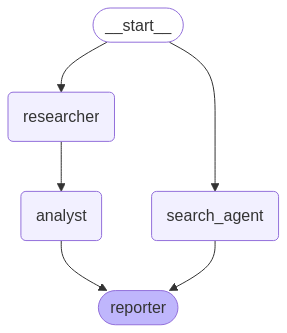


=== R ===
Saya telah mengambil data Bitcoin dari CoinGecko. Berhasil mengambil data Bitcoin untuk 31 hari terakhir. Data siap untuk dianalisis.

=== S ===
Saya telah mendapatkan berita tentang Lakukan analisis Bitcoin dan berikan rekomendasi. analisis Bitcoin berdasarkan data dan analisis teknikal.

=== A ===

Saya telah menganalisis data Bitcoin dan berikut hasilnya:

1. Harga terakhir: $82652.79
2. RSI: 45.81 (Neutral)
3. MACD: 93.0019 dengan Signal Line: 114.1382 (Bearish)
4. EMA 12 vs 26: 85109.9 vs 85016.9 (Bullish)

Berdasarkan analisis teknikal, rekomendasi saat ini adalah: TAHAN
            

=== R ===
Saya telah menyusun laporan lengkap analisis Bitcoin berdasarkan data dan analisis teknikal.

=== R ===
Saya telah menyusun laporan lengkap analisis Bitcoin berdasarkan data dan analisis teknikal.
Last Output : {'reporter': {'messages': [{'role': 'human', 'content': 'Lakukan analisis Bitcoin dan berikan rekomendasi.'}, {'role': 'human', 'content': 'Lakukan analisis Bitcoin dan b

**Ringkasan Eksekutif:**
Berdasarkan analisis data dan indikator teknikal terkini, Bitcoin saat ini berada dalam kondisi "TAHAN". Meskipun terdapat variasi sentimen dari berita terkait, namun secara keseluruhan terdapat optimisme terhadap potensi Bitcoin.

**Analisis Harga dan Tren Bitcoin:**
- Harga Bitcoin berkisar antara $80,752 hingga $94,262 selama 31 hari terakhir.
- Tren harga Bitcoin cenderung fluktuatif namun masih dalam kisaran yang stabil.

**Indikator Teknikal:**
- RSI menunjukkan nilai 45.81, menandakan kondisi "Neutral".
- MACD menunjukkan nilai -93.0019 dengan Signal Line -114.1382, mengindikasikan kondisi "Bearish".
- EMA 12 vs 26 menunjukkan perbedaan yang positif, menunjukkan kondisi "Bullish".

**Analisis Berita:**
- Sentimen berita berkisar antara 20 hingga 80, menunjukkan variasi dalam pandangan terhadap Bitcoin.
- Secara keseluruhan, terdapat optimisme yang cukup kuat terhadap potensi Bitcoin.

**Kesimpulan dan Saran Investasi:**
Berdasarkan analisis, disarankan untuk tetap memantau kondisi pasar dengan cermat dan melakukan analisis teknis yang mendalam sebelum membuat keputusan investasi. Dengan kondisi "TAHAN" saat ini, investor disarankan untuk tidak melakukan transaksi besar-besaran dan tetap waspada terhadap fluktuasi harga Bitcoin.

Demikianlah laporan analisis Bitcoin berdasarkan data dan analisis teknikal terkini. Semoga informasi ini bermanfaat untuk pengambilan keputusan investasi Anda.

In [15]:
## Fungsi untuk mengatur alur antar agen
# def router(state: AgentState) -> str:
#     """Router untuk menentukan agen berikutnya"""
#     return state["next"]

# Membangun graph
def build_bitcoin_analysis_graph():
    # Membuat state graph
    workflow = StateGraph(AgentState)
    
    # workflow.add_node("search", execute_search)
    # workflow.add_edge(START,"search")
    # workflow.add_edge("search",END)

    # Menambahkan node untuk setiap agen
    workflow.add_node("researcher", researcher_agent)
    workflow.add_node("analyst", analyst_agent)
    workflow.add_node("reporter", reporter_agent)
    workflow.add_node("search_agent", search_agent)
    
    # # Menambahkan edge (connection) antar node
    workflow.add_edge(START,"researcher")
    workflow.add_edge(START,"search_agent")
    workflow.add_edge("researcher", "analyst")
    workflow.add_edge("search_agent", "reporter")
    workflow.add_edge("analyst", "reporter")
    # workflow.add_edge("reporter", END)
    
    # # Mengatur start node dan conditionals
    # workflow.set_entry_point(START)
    # workflow.set_finish_point(END)
    # workflow.add_conditional_edges("researcher", router)
    # workflow.add_conditional_edges("analyst", router)
    # workflow.add_conditional_edges("reporter", router)
    
    # Compile graph
    return workflow.compile()

# Fungsi utama untuk menjalankan sistem
def run_bitcoin_analysis():
    # Membangun graph
    graph = build_bitcoin_analysis_graph()


    display(Image(graph.get_graph().draw_mermaid_png()))
    
    # State awal
    initial_state = {
        "messages": [
            {
                "role": "human",
                "content": "Lakukan analisis Bitcoin dan berikan rekomendasi."
            }
        ],
        # "next": "researcher",
        "bitcoin_data": {},
        "technical_analysis": {},
        "report": ""
    }
    
    # Menjalankan graph
    for output in graph.stream(initial_state):
        for key, value in output.items():
            node = key[0]
            state = value
            
            # Cetak output dari setiap agen
            if node != "__end__":
                last_message = state["messages"][-1]["content"]
                print(f"\n=== {node.upper()} ===")
                print(last_message)
    
    # Menampilkan laporan akhir
    print("Last Output :", output)
    final_state = output['reporter']['report']
    print("\n=== LAPORAN LENGKAP ===")
    display(Markdown(final_state))
    
    return final_state

# Contoh penggunaan
if __name__ == "__main__":
    final_result = run_bitcoin_analysis()